# inspect ichthyop simulations

Setup diagnostics:

- absolute dispersion: 
    - maps of probability
    - integrate as a function of distance (probability displacement<1km ...)
    - condition on tides
- relative dispersion
    - setup pdf
    - integrate as a function of distance (probability separation<1km ...)


Rerun with larger dataset (launch every 5 days)


In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram

import taos.mars as ms
import taos.drifters as dr

work_dir = "/home/datawork-lops-osi/aponte/taos/ichthy"

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:50199,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:46396,Total threads: 7
Dashboard: http://127.0.0.1:56416/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:40167,


---

## one lagrangian run

In [3]:
# load 1 arbitrary snapshot for bathy
ds = ms.load_date("2011-01-01 00:00:00")

In [5]:
run = "t_201309"
run = "t_201601"

run_dir = os.path.join(work_dir, run)

dsr = dr.load_run(run_dir)
dsr

<xarray.Dataset>
Dimensions:      (drifter: 500, edge: 1188, latlon: 2, time: 601)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 ... 2016-01-26
Dimensions without coordinates: drifter, edge, latlon
Data variables:
    lon          (time, drifter) float32 ...
    lat          (time, drifter) float32 ...
    mortality    (time, drifter) int32 ...
    depth        (time, drifter) float32 ...
    region_edge  (edge, latlon) float32 ...
Attributes: (12/66)
    transport_dimension:                      3d
    release.schedule.is_enabled:              false
    release.schedule.events:                  "year 2010 month 05 day 13 at 1...
    app.time.initial_time:                    year 2016 month 01 day 01 at 00:00
    app.time.transport_duration:              0025 day(s) 00 hour(s) 00 minut...
    app.time.time_step:                       300
    ...                                       ...
    dataset.mars_3d.field_var_b:              b
    dataset.mars_3d.field_var_u:              UZ
    dataset.mars_3d.field_var_v:              VZ
    dataset.mars_3d.field_var_zeta:           XE
    xml_file:                                 /home/datawork-lops-osi/aponte/...
    nb_zones:                                 0

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

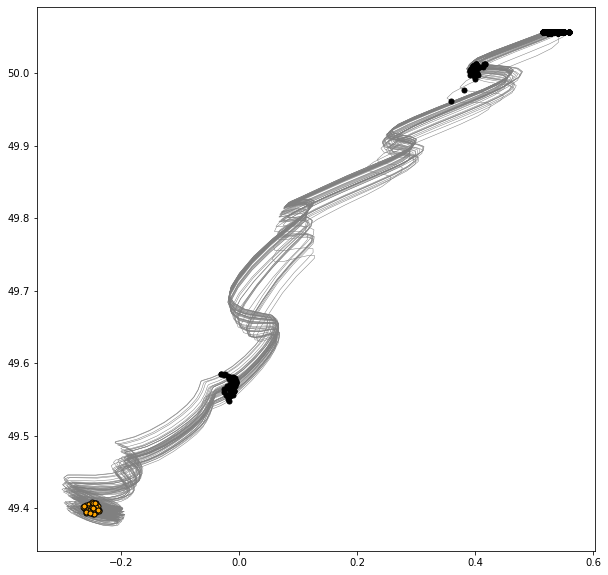

In [6]:
dr.plot_trajectories(dsr, dt=2)

(None,
 <GeoAxesSubplot:title={'center':'water depth [m]'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

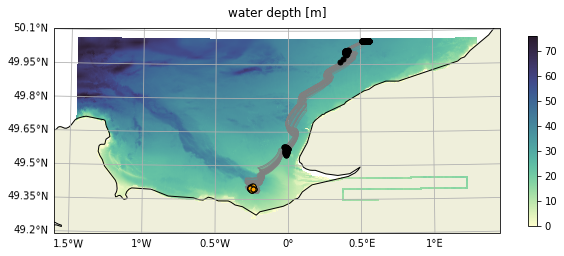

In [8]:
fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
           title="water depth [m]",
           vmin=0,
           cmap=ms.cm.deep,
           zoom=0, figsize=0,
          )

dr.plot_trajectories(dsr, ax=fac["ax"], dt=2)

In [9]:
dsr.isel(drifter=0).mortality

<xarray.DataArray 'mortality' (time: 601)>
array([0, 0, 0, ..., 2, 2, 2], dtype=int32)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-01T01:00:00 ... 2016-01-26
Attributes:
    long_name:      particle cause of mortality
    unit:           death cause
    alive:          0
    dead_cold:      1
    out_of_domain:  2
    old:            3
    beached:        4
    starvation:     5
    dead_hot:       6
    dead_fresh:     7
    dead_saline:    8

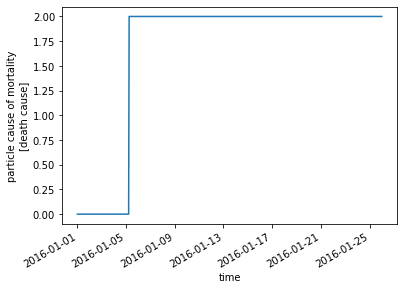

In [10]:
dsr.isel(drifter=0).mortality.plot()

---

## load multiple runs

In [52]:
runs = glob(os.path.join(work_dir, "t_*"))
def norm_time(ds):
    ds["date"] = ds["time"]
    ds["time"] = (ds.time - ds.time[0])/pd.Timedelta("1D")
    return ds

ds_runs = [dr.load_run(r) for r in runs]
ds_runs = [norm_time(d) for d in ds_runs if d is not None]
dsr = xr.concat(ds_runs, dim="run")

### Absolute dispersion

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


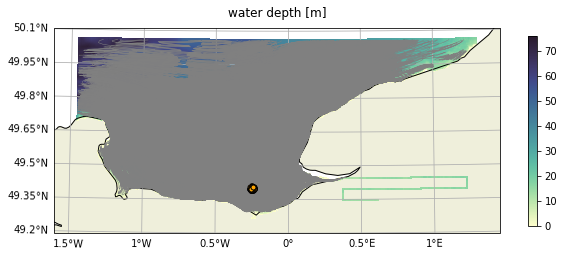

In [25]:
# not great
fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
           title="water depth [m]",
           vmin=0,
           cmap=ms.cm.deep,
           zoom=0, figsize=0,
          )

for _r in dsr.run:
    dr.plot_trajectories(dsr.sel(run=_r), ax=fac["ax"])

In [27]:
dla = 111e3
dlo = float(dla*np.cos(np.pi/180*ds.latitude.mean()))

dl = 2e3 # [m]
lon_bins = np.arange(ds.longitude.min(), ds.longitude.max(), dl/dlo)
lat_bins = np.arange(ds.latitude.min(), ds.latitude.max(), dl/dla)

h = histogram(dsr.lon, dsr.lat, bins=[lon_bins, lat_bins], dim=["run", "drifter"])

In [37]:
#np.log10(h.isel(time=range(0,24*20,24))).plot(x="lon_bin", y="lat_bin", col="time", col_wrap=3)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/aponte/.minico

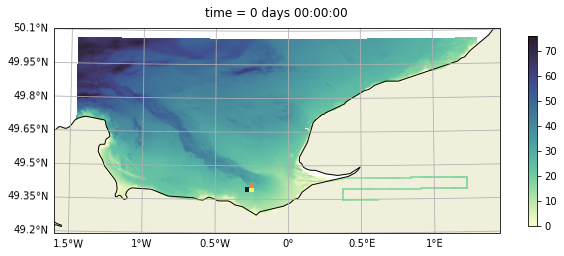

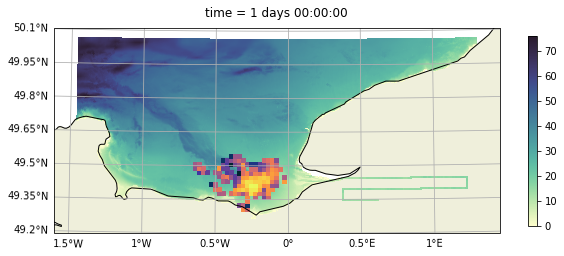

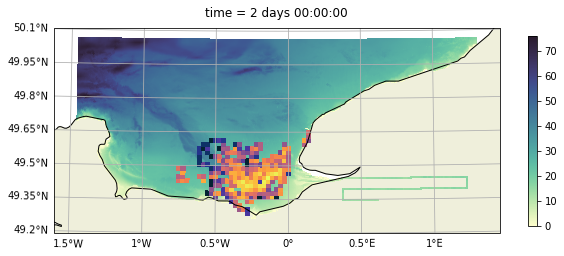

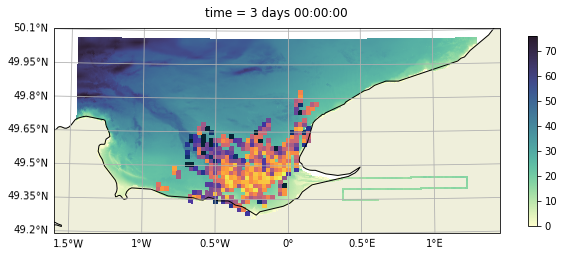

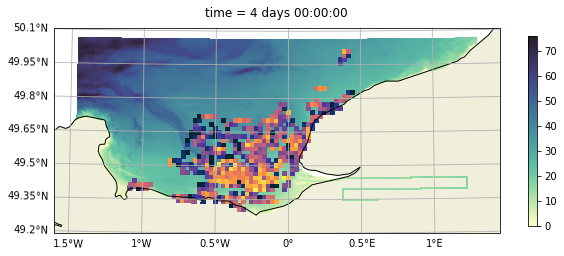

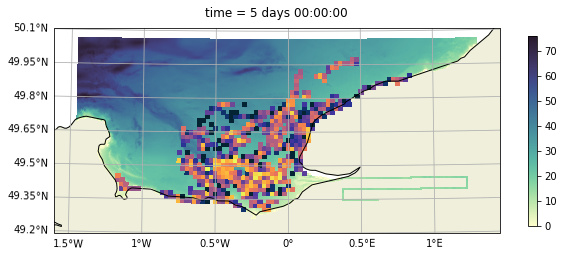

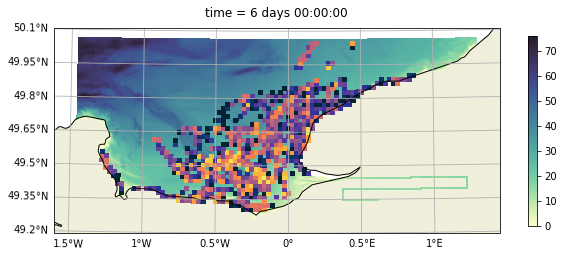

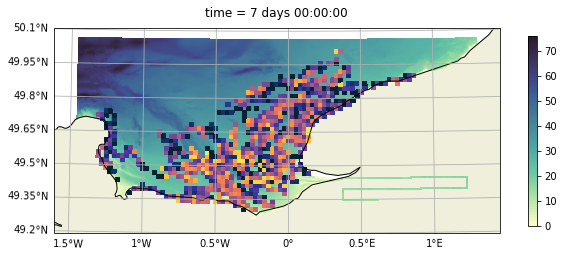

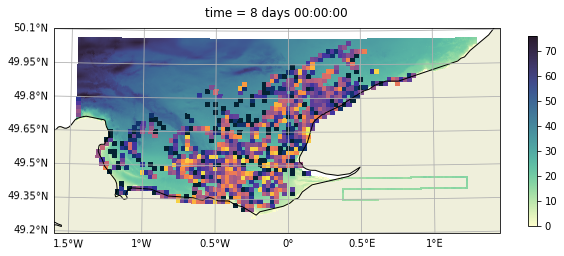

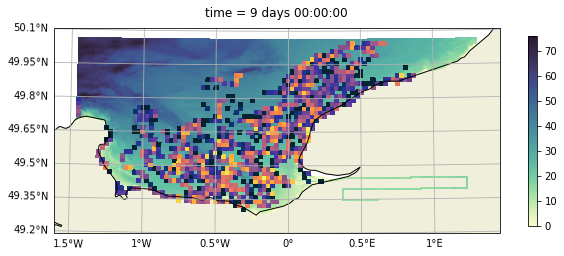

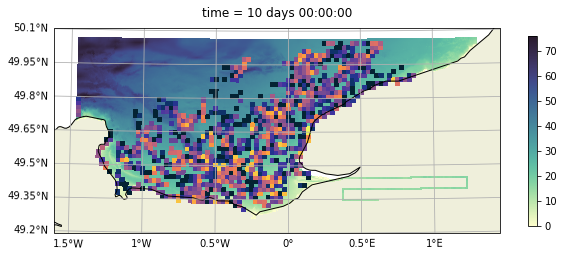

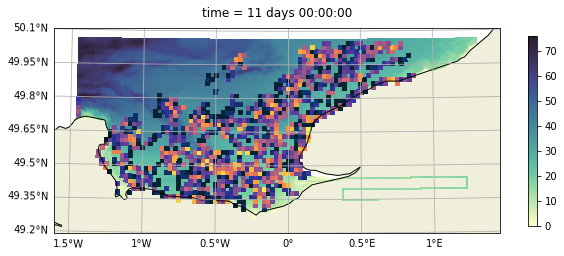

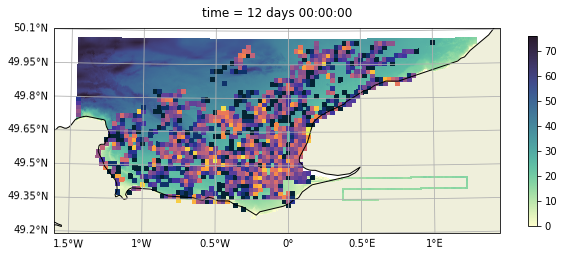

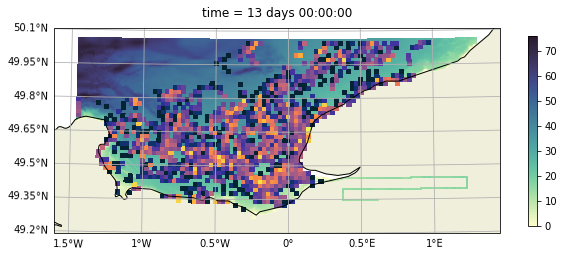

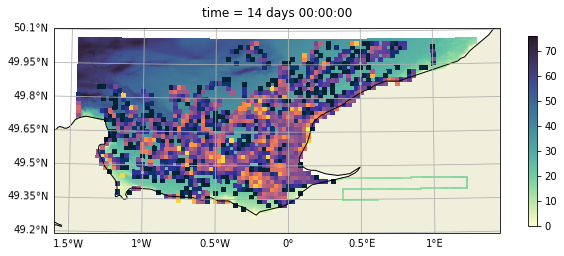

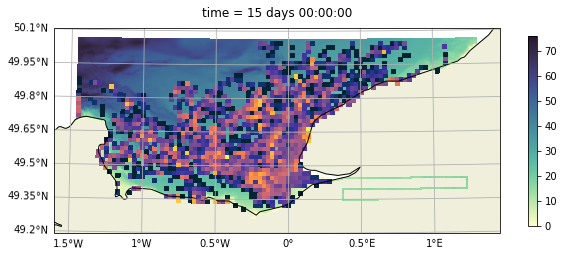

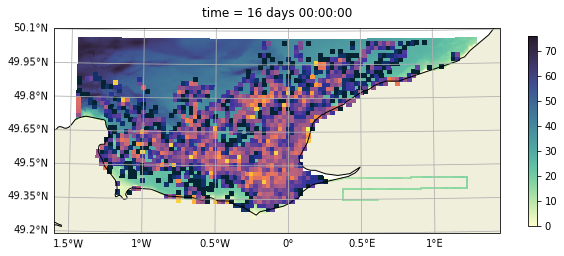

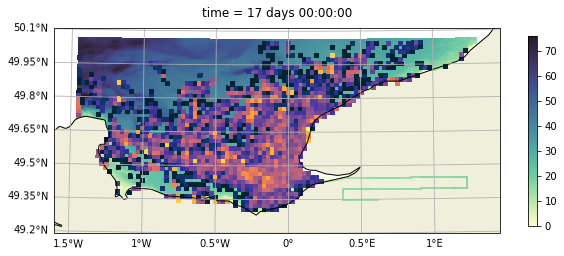

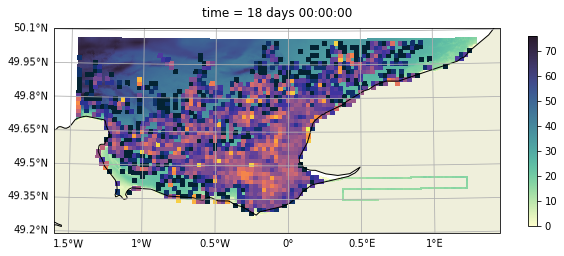

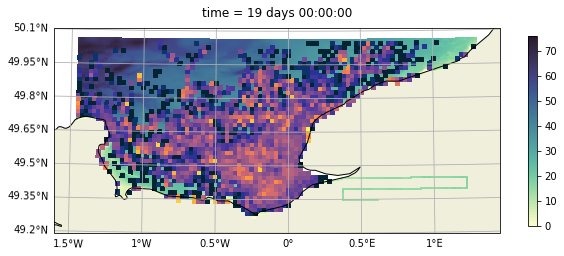

In [36]:
for t in range(0,24*20,24):

    fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
               title="water depth [m]",
               vmin=0,
               cmap=ms.cm.deep,
               zoom=0, figsize=0,
              )
        
    (np.log10(h.isel(time=t))
     .plot
     .pcolormesh(ax=fac["ax"], 
                 x="lon_bin", y="lat_bin",
                 cmap=ms.cm.thermal,
                 add_colorbar=False,
                 transform=dr.ccrs.PlateCarree(),
                )
    )

---
## relative dispersion

In [64]:
# transform lon, lat in local x/y
lon_ref = abs(float(dsr.attrs["release.stain.lon_stain"]))
lat_ref = abs(float(dsr.attrs["release.stain.lat_stain"]))

dla = 111e3
dlo = float(dla*np.cos(np.pi/180*lat_ref))

dsr["x"] = (dsr.lon - lon_ref)*dlo
dsr["y"] = (dsr.lat - lat_ref)*dla

dsr["x_center"] = dsr["x"].mean("drifter")
dsr["y_center"] = dsr["y"].mean("drifter")

dsr["x_relative"] = dsr["x"] - dsr["x_center"]
dsr["y_relative"] = dsr["y"] - dsr["y_center"]

In [67]:

dl = 500 # [m]
l_max = 20e3
x_bins = np.arange(-l_max, l_max, dl)
y_bins = np.arange(-l_max, l_max, dl)

h = histogram(dsr.x_relative , dsr.y_relative, bins=[x_bins, y_bins], dim=["run", "drifter"])

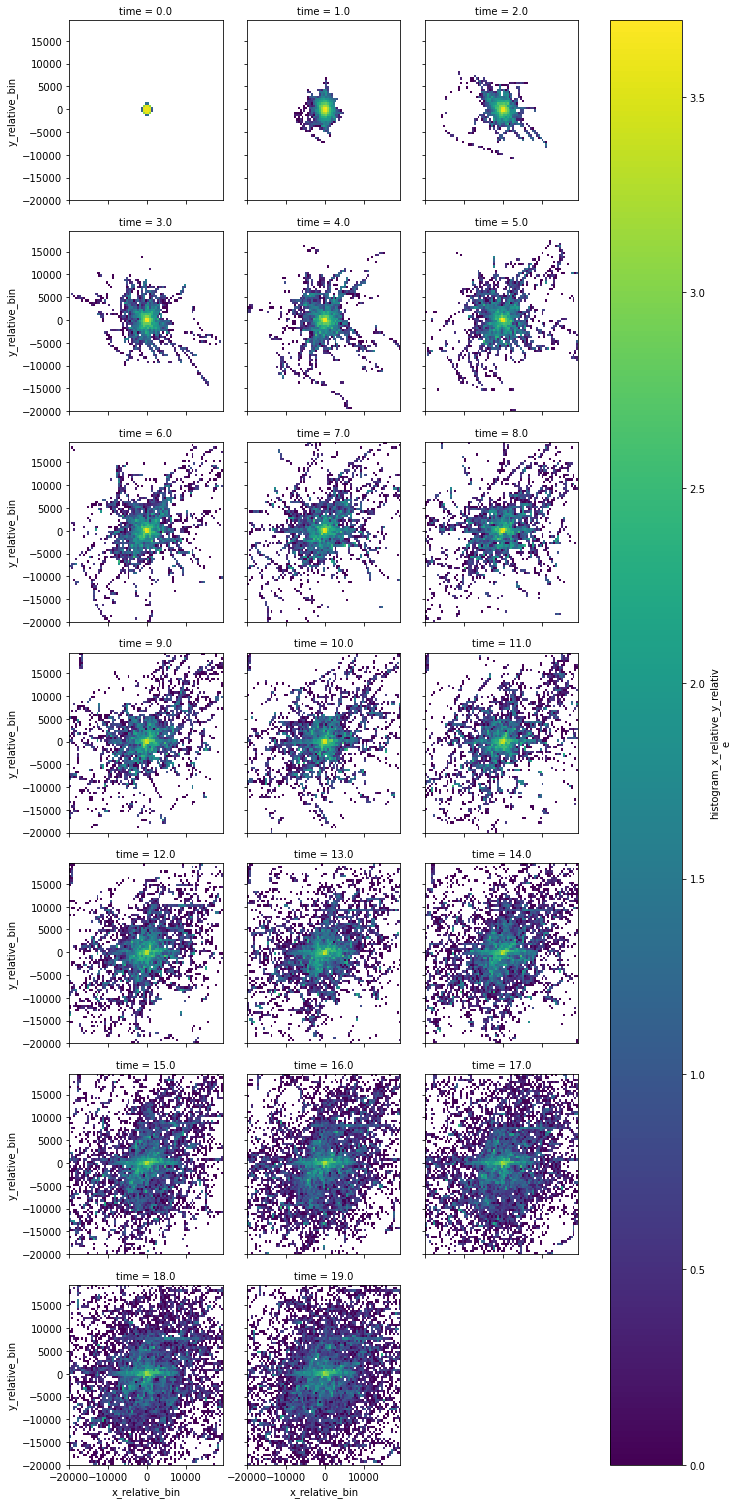

In [68]:
np.log10(h.isel(time=range(0,24*20,24))).plot(x="x_relative_bin", y="y_relative_bin", col="time", col_wrap=3)